In [33]:
import os
import os.path as osp
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array


In [2]:
groundtruth = pd.read_csv("./GroundTruth.csv")
meta = pd.read_csv("./Metadata.csv")
tqdm.tqdm.pandas(desc='Processing Dataframe')
data = meta.merge(groundtruth, how='inner',
                  on='image').sample(frac=1).reset_index(drop=True)
data["target"] = data.progress_apply(lambda x: np.argmax(x[
    ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]]),
    axis=1)
classes = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
classesLabel = dict((i, ele) for i, ele in enumerate(classes))

Processing Dataframe: 100%|██████████| 25331/25331 [00:12<00:00, 2046.35it/s]


In [3]:
groundtruth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
meta.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [5]:
data.head()

,image,age_approx,anatom_site_general,lesion_id,sex,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,target
0,ISIC_0057334,60.0,anterior torso,BCN_0005065,male,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,ISIC_0064533,25.0,lower extremity,BCN_0001234,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,ISIC_0025078,20.0,NaN,HAM_0001512,female,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,ISIC_0061493,70.0,anterior torso,BCN_0001523,female,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5
4,ISIC_0069085,50.0,head/neck,BCN_0001053,female,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4


In [6]:
def center_crop(pil_img):
    img_width, img_height = pil_img.size
    if img_width > img_height:
        crop_size = img_height
    else:
        crop_size = img_width
    return pil_img.crop(
        ((img_width - crop_size) // 2, (img_height - crop_size) // 2,
         (img_width + crop_size) // 2, (img_height + crop_size) // 2))

In [7]:
# data loader
images = []
labels = []
for imageName, target in tqdm.tqdm(list(zip(data['image'], data['target']))):
    try:
        image = Image.open("./FinalDatasets/" + imageName + '.jpg').resize(
            (227, 227))
    except:
        continue
    images.append(np.asarray(center_crop(image)))
    labels.append(target)

25331it [02:10, 193.86it/s]


In [8]:
# list to numpy conversion
images = np.array(images)
labels = np.array(labels)

In [9]:
images.shape

(5983, 227, 227, 3)

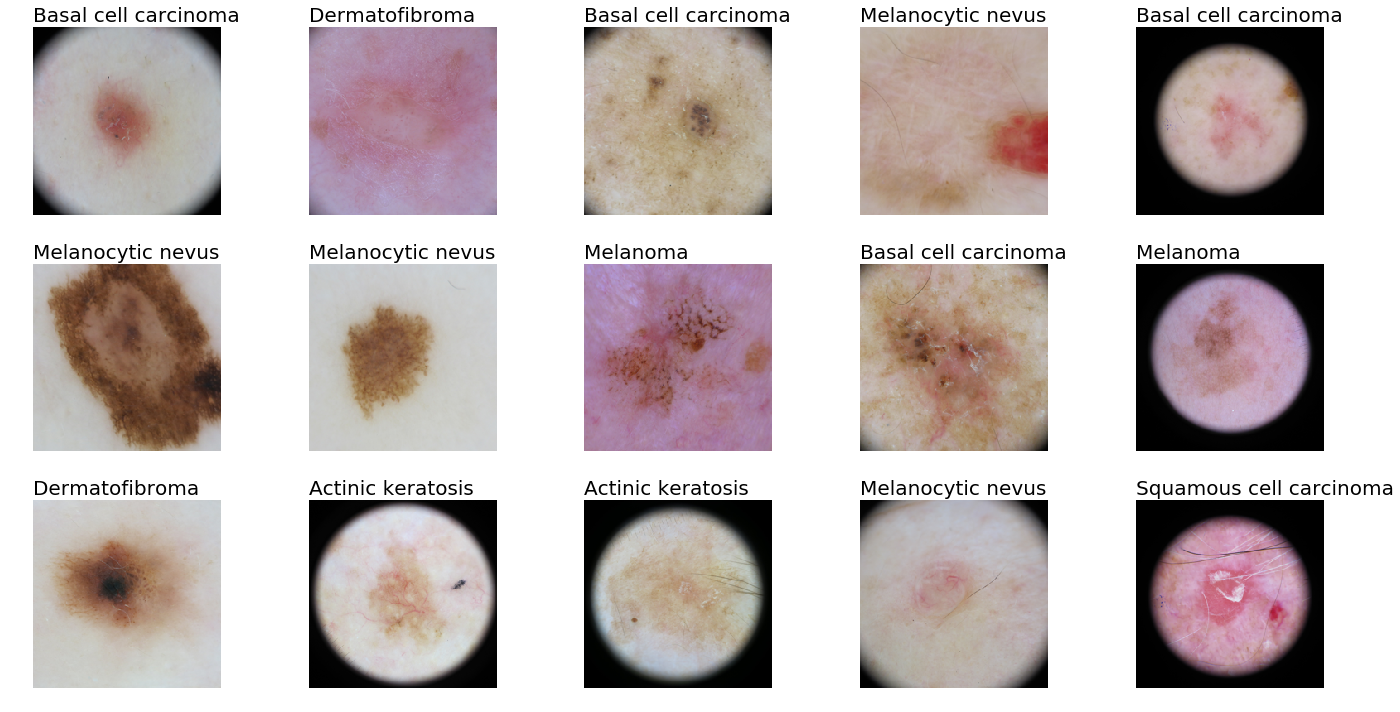

In [10]:
# data visualisation
classesName = [
    'Melanoma', 'Melanocytic nevus', 'Basal cell carcinoma',
    'Actinic keratosis', 'Benign keratosis', 'Dermatofibroma',
    'Vascular lesion', 'Squamous cell carcinoma'
]

fig = plt.figure(figsize=(20, 10))
position = 0
for image, label in zip(images, labels):
    if position == 15:
        break
    plt.subplot(3, 5, position + 1)
    plt.imshow(image)
    plt.title(classesName[label], loc='left', size=20)
    plt.axis('off')
    position += 1

plt.tight_layout()
plt.show()

In [12]:
# spiltting datasets
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size=0.2)

In [13]:
ytrain_binary = to_categorical(ytrain)
ytest_binary = to_categorical(ytest)

In [14]:
# train and test data size
print(xtrain.shape, xtest.shape)

(240, 227, 227, 3) (60, 227, 227, 3)


In [15]:
model_d = DenseNet121(weights='imagenet',
                      include_top=False,
                      input_shape=(227, 227, 3))

x = model_d.output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

preds = Dense(len(classes), activation='softmax')(x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model = Model(inputs=model_d.input, outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 114, 114, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalizationV1) (None, 114, 114, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv3_block10_1_bn (BatchNormal (None, 28, 28, 128)  512         conv3_block10_1_conv[0][0]       
__________________________________________________________________________________________________
conv3_block10_1_relu (Activatio (None, 28, 28, 128)  0           conv3_block10_1_bn[0][0]         
__________________________________________________________________________________________________
conv3_block10_2_conv (Conv2D)   (None, 28, 28, 32)   36864       conv3_block10_1_relu[0][0]       
__________________________________________________________________________________________________
conv3_block10_concat (Concatena (None, 28, 28, 448)  0           conv3_block9_concat[0][0]        
                                                                 conv3_block10_2_conv[0][0]       
__________________________________________________________________________________________________
conv3_block11_0_bn (BatchNormal (None, 28, 28, 448)  1792        conv3_block10_concat[0][0]       
__________

conv5_block5_2_conv (Conv2D)    (None, 7, 7, 32)     36864       conv5_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block5_concat (Concatenat (None, 7, 7, 672)    0           conv5_block4_concat[0][0]        
                                                                 conv5_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block6_0_bn (BatchNormali (None, 7, 7, 672)    2688        conv5_block5_concat[0][0]        
__________________________________________________________________________________________________
conv5_block6_0_relu (Activation (None, 7, 7, 672)    0           conv5_block6_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block6_1_conv (Conv2D)    (None, 7, 7, 128)    86016       conv5_block6_0_relu[0][0]        
__________

In [17]:
for layer in model.layers[:-8]:
    layer.trainable = False

for layer in model.layers[-8:]:
    layer.trainable = True

In [18]:
opt = Adam()
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
trainedModel = model.fit(xtrain,
                         ytrain_binary,
                         validation_data=(xtest, ytest_binary),
                         epochs=20,
                         batch_size=64)

Train on 240 samples, validate on 60 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
240/240 [==============================] - 27s 114ms/sample - loss: 3.3405 - acc: 0.1667 - val_loss: 4.9509 - val_acc: 0.1000
Epoch 2/20
240/240 [==============================] - 26s 108ms/sample - loss: 1.8494 - acc: 0.4292 - val_loss: 5.1871 - val_acc: 0.0833
Epoch 3/20
240/240 [==============================] - 26s 108ms/sample - loss: 1.5113 - acc: 0.5125 - val_loss: 5.5959 - val_acc: 0.1667
Epoch 4/20
240/240 [==============================] - 26s 108ms/sample - loss: 1.0954 - acc: 0.6042 - val_loss: 5.5198 - val_acc: 0.1833
Epoch 5/20
240/240 [==============================] - 26s 108ms/sample - loss: 0.7116 - acc: 0.7583 - val_loss: 6.0784 - val_acc: 0.1500
Epoch 6/20
240/240 [==============================] - 27s 112ms/sample - loss: 0.7037 - acc: 0.7375 - val_loss: 6.2703 - val_acc: 0.1500
Epoch 7/20
240/240 [==============================] - 30s 123ms/sample - loss: 0.6840

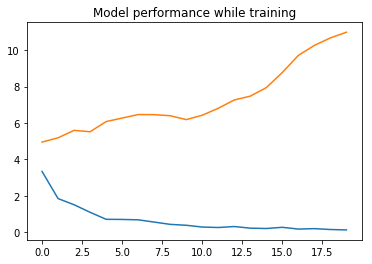

In [23]:
train_loss = trainedModel.history['loss']
val_loss = trainedModel.history['val_loss']
train_acc = trainedModel.history['acc']
val_acc = trainedModel.history['val_acc']
xc = list(range(20))

# plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.title("Model performance while training")
plt.show()

In [24]:
model.evaluate(xtest, ytest_binary, verbose=1)

60/60 [==============================] - 9s 144ms/sample - loss: 10.9844 - acc: 0.1167


[10.984426689147949, 0.11666667]

In [35]:
testImage = "./FinalDatasets/ISIC_0015160_downsampled.jpg"
image = Image.open(testImage).resize((227, 227))
image = np.asarray(center_crop(image))

In [36]:
pred = model.predict(image.reshape(-1, 227,227,3))

Label : BKL
Skin Lesion Name : Benign keratosis


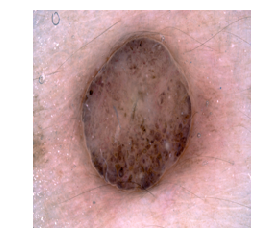

In [38]:
className = classes[np.argmax(pred)]
plt.imshow(Image.fromarray(image))
plt.axis('off')
print('Label :', className)
print('Skin Lesion Name :', classesName[np.argmax(pred)])